In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import warnings
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target

In [2]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


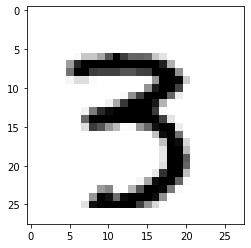

In [3]:
some_digit = X[27553]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, matplotlib.cm.binary, interpolation= 'nearest')
plt.show()

In [4]:
y[27553]

'3'

dividing trINING SET and test set

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000], y[60000:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
shuffle = np.random.permutation(60000)
X_train, y_train = X_train[shuffle], y_train[shuffle] 
print(X_train.shape)
print(y_train.shape)
print(y_train)

(60000, 784)
(10000, 784)
(60000,)
(10000,)
(60000, 784)
(60000,)
['2' '7' '8' ... '6' '0' '8']


**1 Train a Binary Classifier**
We are going to train a binary classifier on a single number, say 3. We will use this to prove why accuracy may not be the best performance metric in this situation.

The classifier model used will be Stochastic Gradient Descent. SGD has the advantage of being capable of handling very larget datasets efficiently (because it handles training instances independently; it's well suited for online learning).

In [6]:
y_train = y_train.astype(np.int8) #to convert y_train to int from string
print(y_train)
y_train_3 = (y_train==3)
y_test_3 = (y_test==3)
print(y_train_3)
print(y_test_3)

from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier(n_jobs = -1, random_state = 42)
sgd_classifier.fit(X_train, y_train_3)

[2 7 8 ... 6 0 8]
[False False False ... False False False]
[False False False ... False False False]


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

prediction of single value ie 3 to check accuracy

In [7]:
prediction = sgd_classifier.predict([some_digit])
print(prediction)

[ True]


prediction succeded classifier guessed perfectly
now checking accuracy

In [8]:
from sklearn.model_selection import cross_val_score
accuracy = cross_val_score(sgd_classifier, X_train, y_train_3, cv = 3, scoring = 'accuracy') 

In [9]:
print(accuracy * 100)

[96.175 96.415 96.1  ]


as the accuracy is over 94 % therefore checking the accuracy of the other half ie not 3

In [10]:
from sklearn.base import BaseEstimator
class Never3Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)
never_3 = Never3Classifier()
accuracy = cross_val_score(never_3, X_train, y_train_3, cv =3, scoring = 'accuracy')
print(accuracy)

[0.89885 0.89865 0.89595]


as the accuracy is still over 89% thus proves that accuracy is not the best metric. as the the dataset is pretty balanced how each digit is represented now using confusion matrix

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_3, cv = 3,n_jobs = -1)
confusion_matrix = confusion_matrix(y_train_3, y_train_pred)

In [12]:
print(confusion_matrix)

[[53178   691]
 [ 1571  4560]]


predicted not 3 and actualy not 3 = 52166    [tn]
predicted to be 3 but actualy not 3 = 1703   [fp]
predicted not 3 but actually  3 = 1080       [fn]
predicted 3 but actualy 3 = 5051             [tp]



Checking precision and recall

In [13]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_3, y_train_pred)
print(precision * 100)
recall = recall_score(y_train_3, y_train_pred)
print(recall * 100)

86.84060179013521
74.37612135051378


precision and recall by hand

In [14]:
precision_byhand = 5051/((5051+1703))
print(f'Precision by hand = {precision_byhand * 100}')
recall_byhand = 5051/((5051+1080))
print(f'Recall by hand = {recall_byhand * 100}')

Precision by hand = 74.78531240746224
Recall by hand = 82.38460283803622


f1 score

In [15]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_train_3, y_train_pred)
print(f1_score)

0.8012651555086979


So how do we know which threshold to use for our classifier?
First we need to find the decision scores of our classifier by calling for `decision function` instead of accuracy
Then we plot Precision and Recall curves
From that curve we can conclude a threshold score

These are fundamental tools to evaluate and fine tune a classifier. Consider this example
If our classifier claims that “these 10 images have an apple in it” but in reality only 8 images contain apples then the precision is 0.8 or 80%
If we give 10 images with apples to our classifier but it recognizes only 7 and rejects 3 then its recall is 0.7 or 70%
If we aim for higher precision we compromise on recall and vice versa
Ideally we want both high precision and high recall. But we need to find a thresholdvalue so that there is a trade-off

#default threshold:

In [16]:
y_scores = sgd_classifier.decision_function([some_digit])
y_scores

array([5514.23700298])

In [17]:
y_scores = cross_val_predict(
    sgd_classifier, 
    X_train, 
    y_train_3, 
    cv=3,
    method="decision_function")

In [18]:
# use results to build a precision/recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_train_3, y_scores)

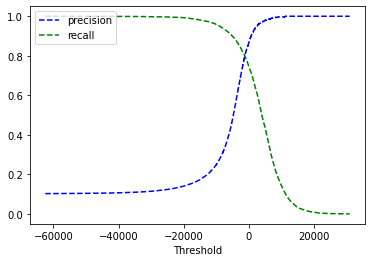

In [19]:
#plot precision, recall curve vs threshold to find the best threshold
def precision_recall_vs_thresholds(precision, recall, thresholds):
  plt.plot(thresholds, precision[:-1], "b--", label = "precision")
  plt.plot(thresholds, recall[:-1], "g--", label = "recall")
  plt.legend(loc = 'upper left')
  plt.xlabel('Threshold')
  plt.show()
precision_recall_vs_thresholds(precision, recall, thresholds)

here we can see the threshold value is approx 2000
now checking the the precision and recall curve to see at which point the precision increases and recall decreses also known as knee to find accuracy

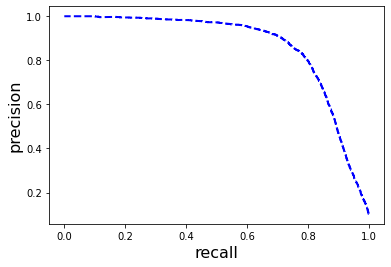

In [20]:
def precision_vs_recall_curve(precision, recall):
  plt.plot(recall, precision, "b--" ,linewidth = 2)
  plt.xlabel('recall', fontsize = 16)
  plt.ylabel('precision', fontsize = 16)
  plt.show()
precision_vs_recall_curve(precision, recall)

here we can see the recall falls over 80% thus increasing precision so lets aim for precision over 90%. considering 2000 as our opimal threshold

In [21]:
y_train_pred_90 = (y_scores > 3000)
print(y_train_pred_90.shape)
print(y_train_pred_90)

(60000,)
[False False False ... False False False]


In [22]:
pr = precision_score(y_train_3, y_train_pred_90)*100
re = recall_score(y_train_3, y_train_pred_90)*100
print(f'precision = {pr}')
print(f'recall = {re}')

precision = 96.14015877361072
recall = 57.282661882237804


So by using optimal threshold value ie 3000 the precision is over 90 % and

recall is over 58% so This way we can tune our model as per needs. Its like a knob you turn.

# ROC Curve

ROC curve is called Reciver Operating Charachteristic
-ROC is Receiver operating characteristic
-Sensitivity = Recall = True Positive Rate
-Specificity = True Negative Rate
-False Positive Rate = 1 — Specificity
-The more the area under the curve the better our classifier

ROC curve is plotted between tpr(TRUE POSITIVE RATE) and fpr(FALSE POSITIVE RATE)

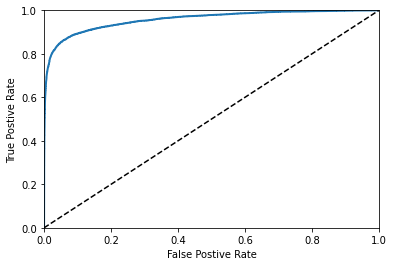

In [23]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0 , 1],[0, 1], 'k--')
  plt.axis([0 ,1 ,0 ,1])
  plt.xlabel('False Postive Rate')
  plt.ylabel('True Postive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

Now calculating roc and auc SCORE that is ther area under the curve, the more are the more better is model, thus compare areA with other classififers or models and choose the best one

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_3, y_scores) * 100

95.78144408928576

#Random Forest
now considering other classififer such as random forest classifier 
to compare the 2 methods for classification via ROC curve

In [25]:
from sklearn.ensemble import RandomForestClassifier
rforest_classifier = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(rforest_classifier, X_train, y_train_3, cv=3, method="predict_proba") 
print(y_proba_forest[:,1])

[0.   0.   0.32 ... 0.08 0.01 0.03]


Random Forest Classifier gives us an array of probabilities. Rows are instances and columns are classes ( not-5 or 5 )

In [26]:
y_scores_forest = y_proba_forest[:, 1]
print(y_scores_forest)
#considering first row and first column as they contain probability of positive class

[0.   0.   0.32 ... 0.08 0.01 0.03]


Now we plot the ROC curves for this classifier. All steps are similar


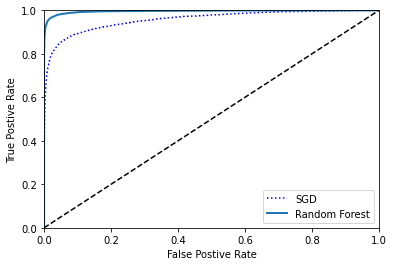

In [27]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3, y_scores_forest)
plt.plot(fpr, tpr, "b:", label = 'SGD')
plt.legend()
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend()
plt.show()

See how Random Forest is more stretched to the left covering more area?
So it performs better than the Stochastic Gradient Descent classifier
Let’s find the area under the curve

In [28]:
rforest_roc_scores = roc_auc_score(y_train_3, y_scores_forest)
print(rforest_roc_scores * 100)
#FOR SGD it was 96 thus this is a better fit model for this dataset

99.58834966958739


#MULTICLASS CLASSIFICATION

Up till now we did 5 or not-5 i.e. binary classification
When there are more than two classes its a multi-class or multi-nomial classification
In our case we have 0,1,2…..9 i.e. 10 digits = 10 classes in all
Random Forest and Naive Bayes are capable to handle multi classes directly
Support Vector machine(SVM) and Linear classifiers are binomial classifiers

Now we can explore making a classifier that can classify multiple classes (Binary only distinguished between two classes). Algorithms such as Random Forest or Naive Bayes are capable of handling multiple classes, while some such as Support Vector Machine or Linear classifiers can only be binary classifiers.

Most Binary classification algorithms scale better with OvA (One-versus-all) while some algorithms such as SVM scale better with OvO (One-versus-one) strategy. Scikit-Learn detects what strategy to use automatically.

In [29]:
sgd_classifier.fit(X_train, y_train) #training with X_train and y_Train instead of y_train_3
prediction = sgd_classifier.predict([some_digit])
print(prediction)

[3]


In [30]:
some_digit_scores = sgd_classifier.decision_function([some_digit])
highest_value_to_which_class = np.argmax([some_digit_scores])
print(f"Highest value belong to the class = {highest_value_to_which_class}")

Highest value belong to the class = 3


the SGD classifier classifies the 10 binary as 0 or 1.Thus it uses the OVA as the strategy.this can be confirmed by see the highest value belonging to class 3

You can always force Scikit-Learn to use OvO or OvA by using the OneVsOneClassifier or OneVsRestClassifier

In [31]:
cross_val_score(sgd_classifier, X_train, y_train, cv=3, scoring='accuracy')

array([0.8885 , 0.86955, 0.88005])

we can achive better accuracy by standard scaling

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_classifier, X_train_scaled, y_train, cv = 3, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.9029 , 0.90555, 0.89575])

#Using a RandomForestClassifier:

In [33]:
rforest_classifier.fit(X_train, y_train)
r_forest_prediction = rforest_classifier.predict([some_digit])
print(r_forest_prediction)

[3]


In [34]:
rforest_classifier.predict_proba([some_digit])

array([[0.  , 0.  , 0.  , 0.96, 0.  , 0.  , 0.  , 0.  , 0.01, 0.03]])

# Error Analysis
Assuming our model is best fit but we want to look the ways to improve it. The best way to analize the model by Error Analysis. The first step is the confusion matrix.

In [35]:
y_train_pred = cross_val_predict(sgd_classifier, X_train_scaled, y_train, cv = 3, n_jobs=-1)

In [36]:
from sklearn.metrics import confusion_matrix
xyz = confusion_matrix(y_train, y_train_pred)
xyz

array([[5596,    0,   17,    8,   10,   38,   35,    5,  213,    1],
       [   0, 6426,   41,   20,    3,   41,    6,    6,  186,   13],
       [  26,   28, 5256,   90,   74,   23,   58,   39,  355,    9],
       [  32,   23,  108, 5242,    2,  214,   26,   41,  379,   64],
       [  11,   17,   43,    7, 5247,    7,   37,   25,  289,  159],
       [  25,   18,   29,  158,   50, 4483,   77,   14,  495,   72],
       [  30,   18,   52,    2,   43,   87, 5560,    6,  120,    0],
       [  21,   13,   52,   27,   48,   12,    3, 5694,  169,  226],
       [  18,   62,   37,   94,    1,  123,   32,    9, 5428,   47],
       [  24,   20,   28,   63,  123,   41,    1,  180,  317, 5152]])

In [37]:
xyz.shape

(10, 10)

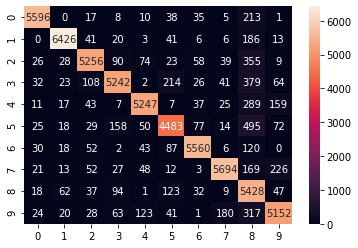

In [38]:
import seaborn as sns
sns.heatmap(xyz, annot = True, fmt = 'd')

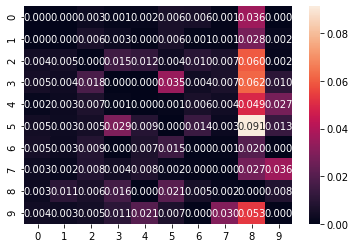

In [39]:
row_sum = xyz.sum(axis = 1, keepdims= True)
norm_xyz = xyz/row_sum
np.fill_diagonal(norm_xyz, 0)
sns.heatmap(norm_xyz, annot = True, fmt = '.3F') 

Diagonal is pitch black as we wanted
Brighter colors represent larger errors
See columns 8 and 9? Lot of bright patches. This means many digits are mis-classified as 8 or 9
See rows 8 and 9? Again brighter patches. This means 8 and 9 are often mis-classified!

There are many ways to correct this problem like image rotation, shifting, reducing noise which we cannot cover at the moment.
Summary

#Multilabel Classification

In a classification such as face recognition, we want to make sure that we are able to represent our prediction in a binary output with multiple labels. For example, if our categories are "Alice", "Bob", and "Charlie", then a picture of Alice and Charlie should output [1,0,1]. Such classification that outputs multiple labels is called Multilabel Classification. We can use an example with the MNIST data to illustrate this. Let's use the K-Neighbors Classifier:

In [40]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odds = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odds]
print(y_multilabel)
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_multilabel)
knn_classifier.predict([some_digit])

[[False False]
 [ True  True]
 [ True False]
 ...
 [False False]
 [False False]
 [ True False]]


array([[False,  True]])

We defined two labels in the above example: "Large" digit (7,8,9) and "Odd" digit (1,3,5,7,9). Given that, we predicted that the digit 3 is False on greater than 7 and true on odd labels, and that's correct: 4 is large and odd.

So in here multiple labels are greter than and odd this is an example of multilabel class

There are many ways to evaluate multilabel classifier: we can measure the F1 score for each label then compute the average:

We can always weigh the labels by how important they are (i.e., there is probably more odd digits than large digits, so odd digits should be weighed more) by setting average="weighted"

#Multioutput Classification
The last type of classification task is the multioutput classification, where each label can have more than 2 classes of output. In this example, we will still use the MNIST dataset; however, we will insert random noise that will appear as different shades of grey on each pixel.

In [41]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

We can "peak" at one of the test digits, one with the noise added and the target digit with no noise.

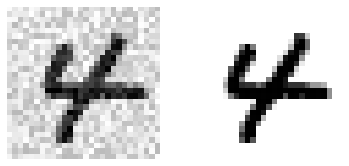

In [42]:
some_index = 5500
def plot_digit(some_digit):
  some_digit_image = some_digit.reshape(28, 28)
  plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
  plt.axis('off')
plt.subplot(121);
plot_digit(X_test_mod[some_index])
plt.subplot(122);
plot_digit(y_test_mod[some_index])

when you do subplot(1,2,1); or subplot(121); , you would like to have one row and two columns worth of figures. The last number, p=1 means that you wish to place the plot in the left most column.

Now we can train the noise "4" and see how it cleans up compared to the target image.

In [43]:
%time knn_classifier.fit(X_train_mod, y_train_mod)
clean_digit = knn_classifier.predict([X_test_mod[some_index]])

CPU times: user 14.1 s, sys: 97 ms, total: 14.2 s
Wall time: 14.2 s


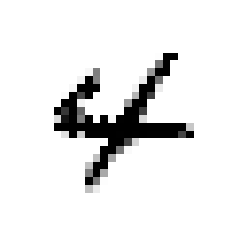

In [44]:
plot_digit(clean_digit)
plt.show()

While it is not quite the target digit, it is close enough to be able to make a prediction.